<a href="https://colab.research.google.com/github/MahparaBadar/Deep-Learning/blob/main/Brain_Tumor_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

100%|██████████| 15.1M/15.1M [00:00<00:00, 48.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 60% 9.00M/15.1M [00:00<00:00, 93.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 98.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
tumor = []
healthy = []
for f in glob.iglob("/content/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("/content/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(10, 5, replace=False)

array([7, 0, 6, 3, 9])

In [ ]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


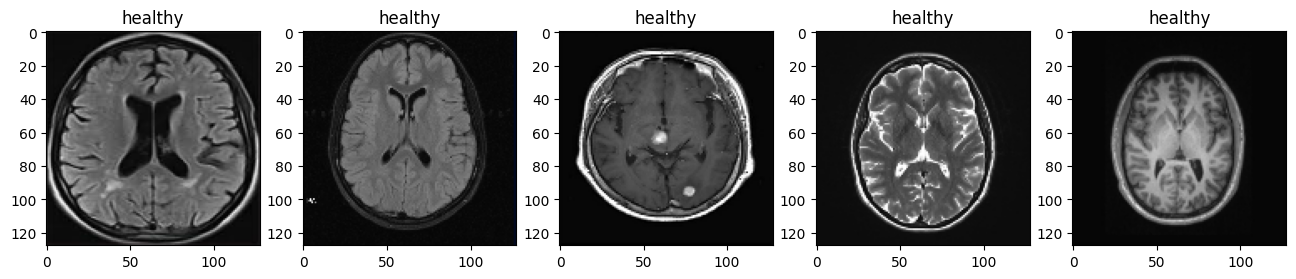

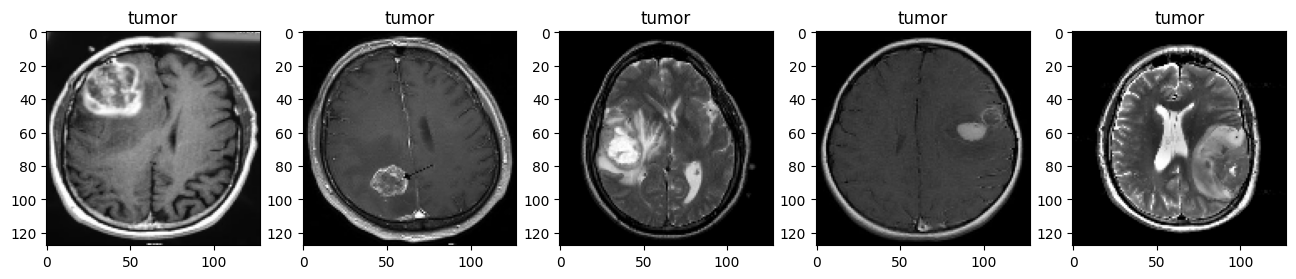

In [ ]:
plot_random(healthy, tumor, num=5)

In [ ]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [ ]:
class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()

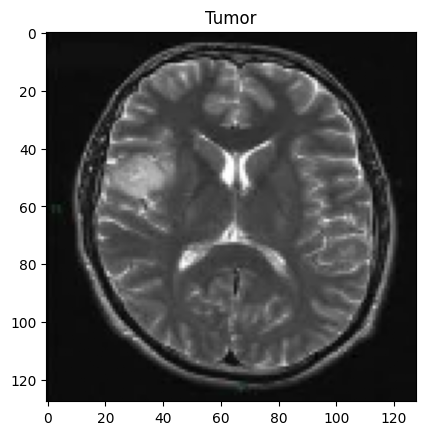

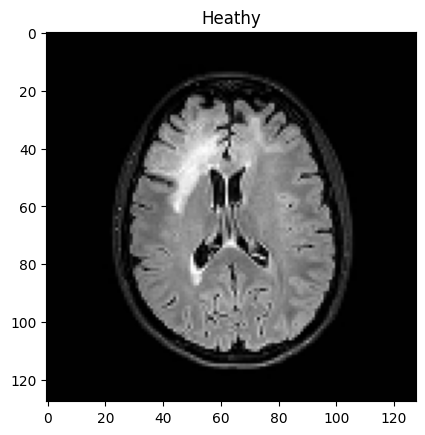

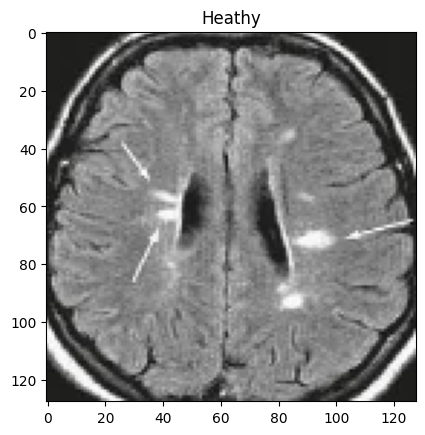

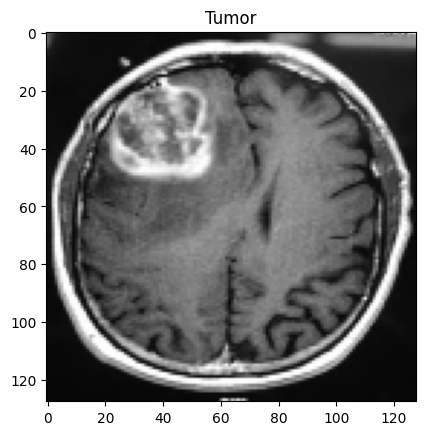

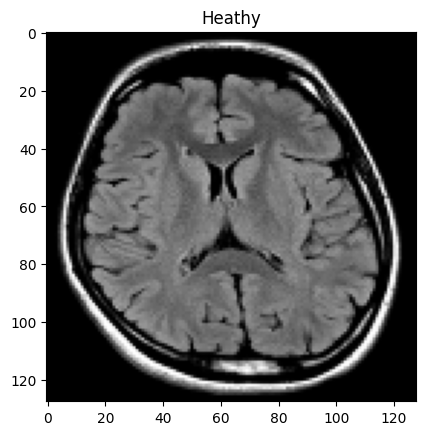

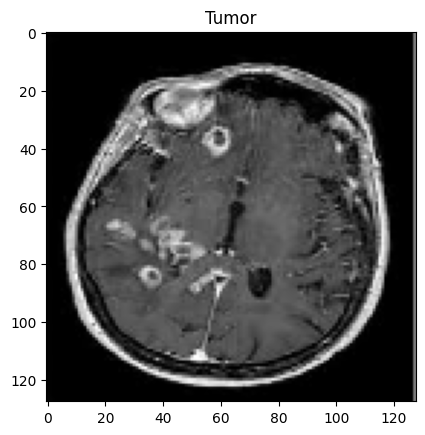

In [ ]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


In [ ]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([1.0000, 0.8337, 0.1081, 0.2294, 0.1088, 0.3341, 0.3313, 0.9202, 0.4733,
        0.7114], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([1.0000, 0.8337, 0.1081, 0.2294, 0.1088, 0.3341, 0.3313, 0.9202, 0.4733,
        0.7114], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.9999, 0.6950, 0.0117, 0.0526, 0.0118, 0.1116, 0.1097, 0.8469, 0.2240,
        0.5060], device='cuda:0')


In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [ ]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [ ]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [ ]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
accuracy_score(y_true, threshold(outputs))

0.49707602339181284

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

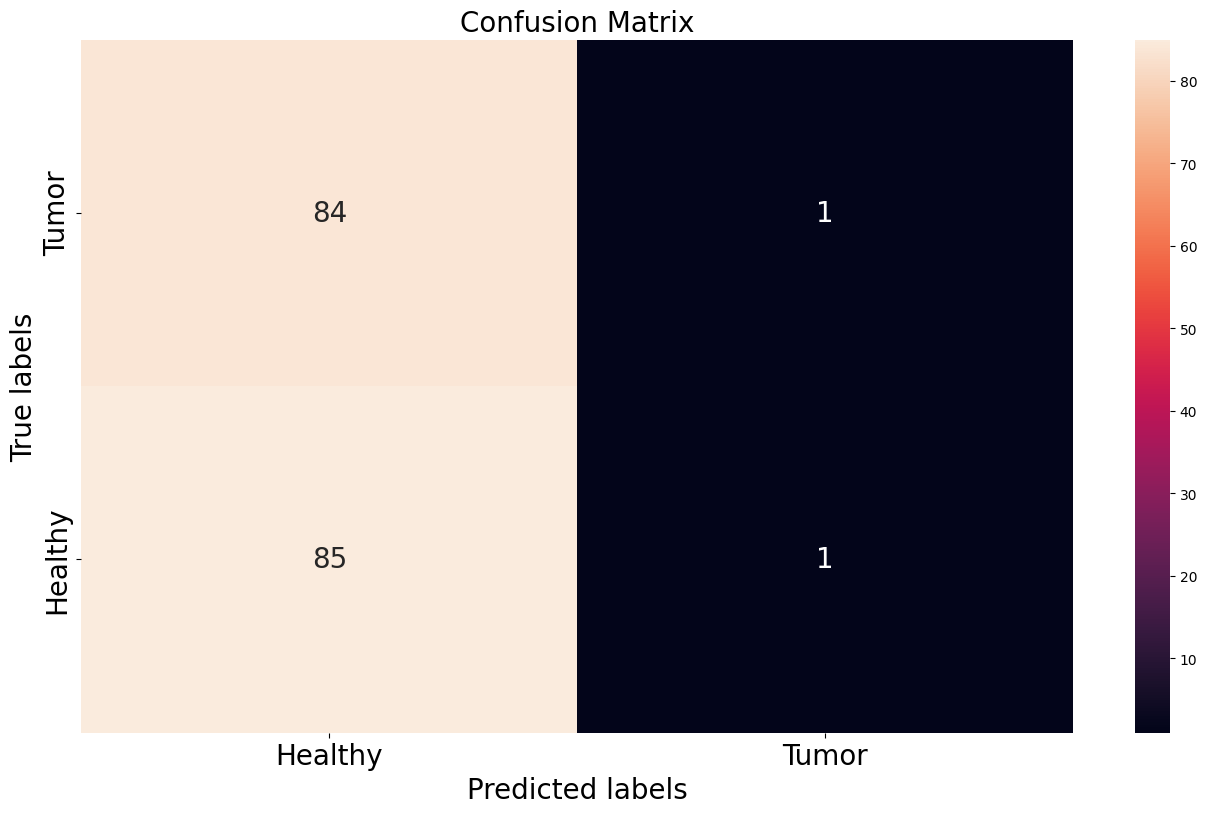

In [ ]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

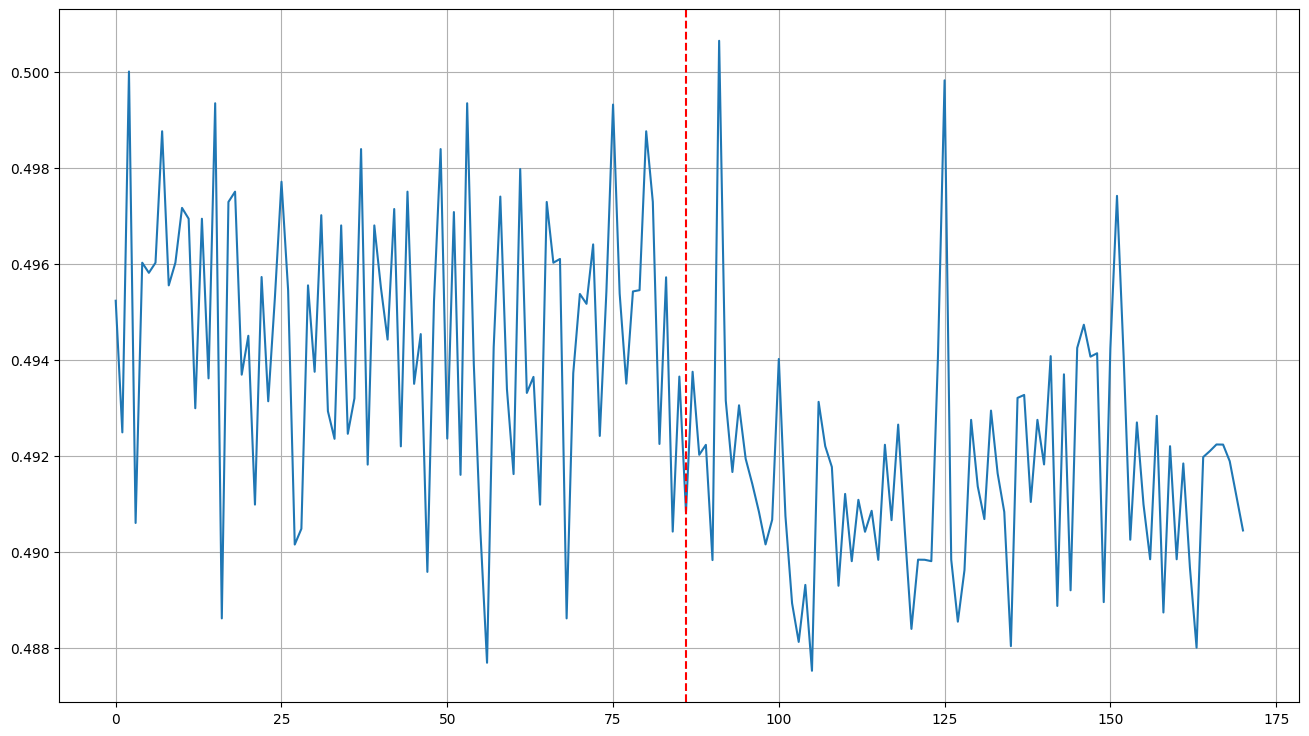

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.668578
Train Epoch: 20	Loss: 0.629368
Train Epoch: 30	Loss: 0.569390
Train Epoch: 40	Loss: 0.522104
Train Epoch: 50	Loss: 0.475917
Train Epoch: 60	Loss: 0.455481
Train Epoch: 70	Loss: 0.413265
Train Epoch: 80	Loss: 0.407214
Train Epoch: 90	Loss: 0.362746
Train Epoch: 100	Loss: 0.334400
Train Epoch: 110	Loss: 0.297517
Train Epoch: 120	Loss: 0.290202
Train Epoch: 130	Loss: 0.268667
Train Epoch: 140	Loss: 0.261296
Train Epoch: 150	Loss: 0.235540
Train Epoch: 160	Loss: 0.217428
Train Epoch: 170	Loss: 0.184277
Train Epoch: 180	Loss: 0.185139
Train Epoch: 190	Loss: 0.158888
Train Epoch: 200	Loss: 0.129748
Train Epoch: 210	Loss: 0.131881
Train Epoch: 220	Loss: 0.100286
Train Epoch: 230	Loss: 0.082799
Train Epoch: 240	Loss: 0.077627
Train Epoch: 250	Loss: 0.064385
Train Epoch: 260	Loss: 0.048583
Train Epoch: 270	Loss: 0.039036
Train Epoch: 280	Loss: 0.034005
Train Epoch: 290	Loss: 0.032913
Train Epoch: 300	Loss: 0.023872
Train Epoch: 310	Loss: 0.018122
Train Epoch: 320	

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

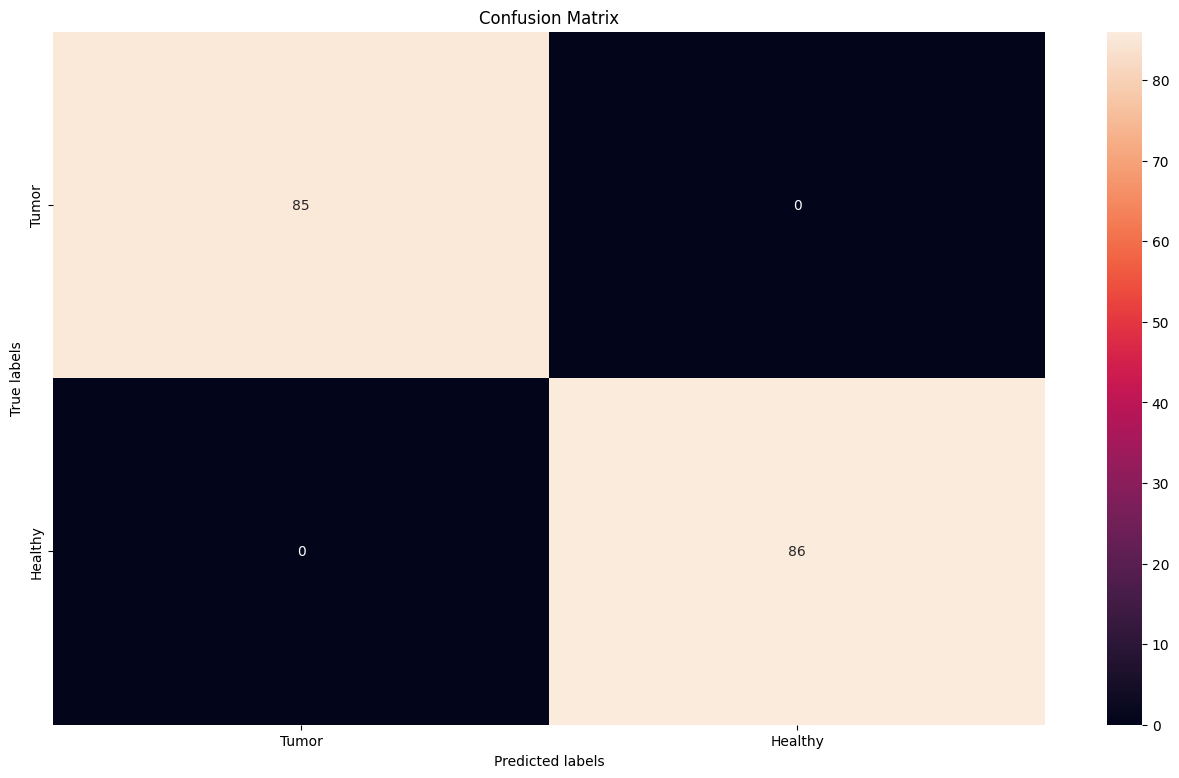

In [ ]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

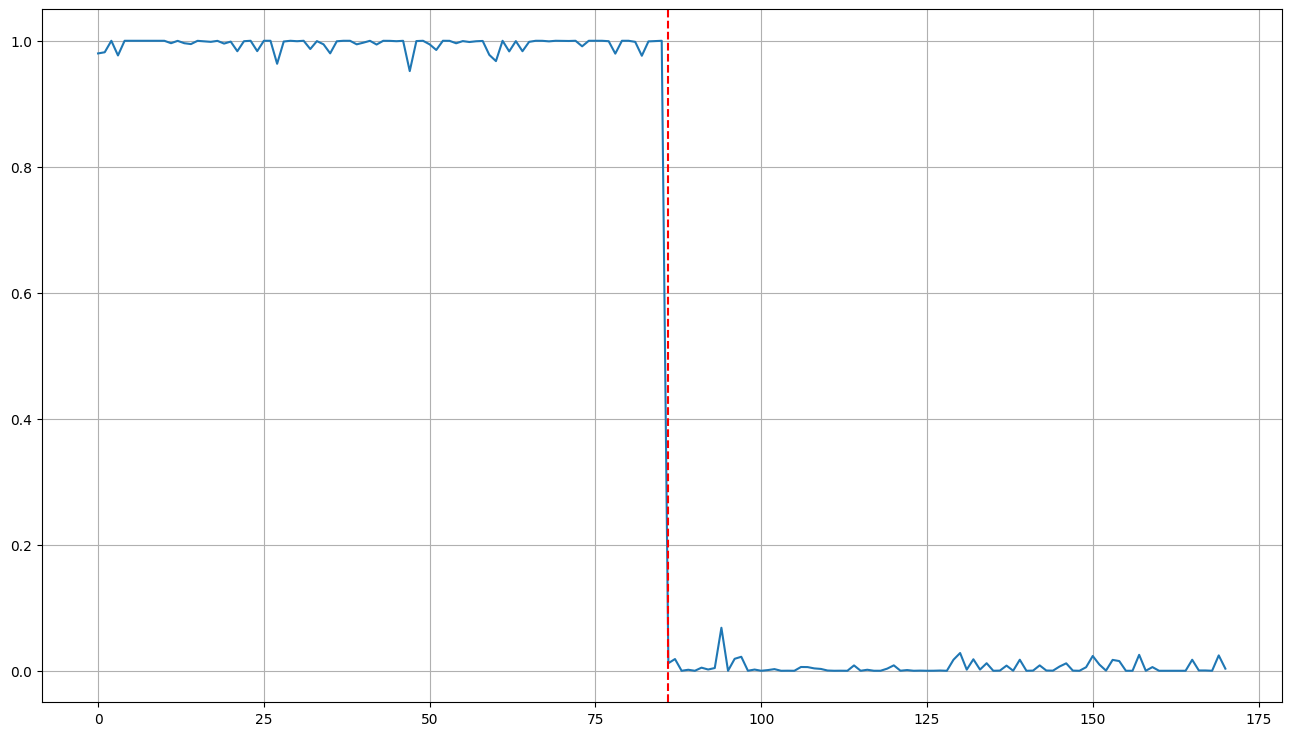

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

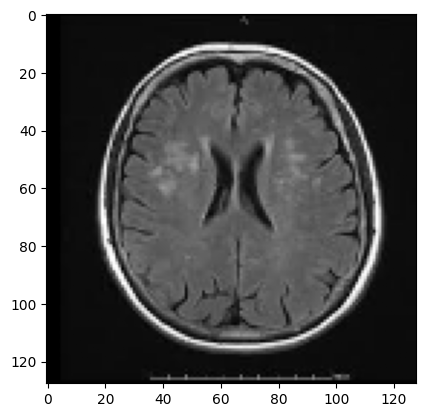

In [ ]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [ ]:
img = torch.from_numpy(img).to(device)

In [ ]:
img.shape

torch.Size([3, 128, 128])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


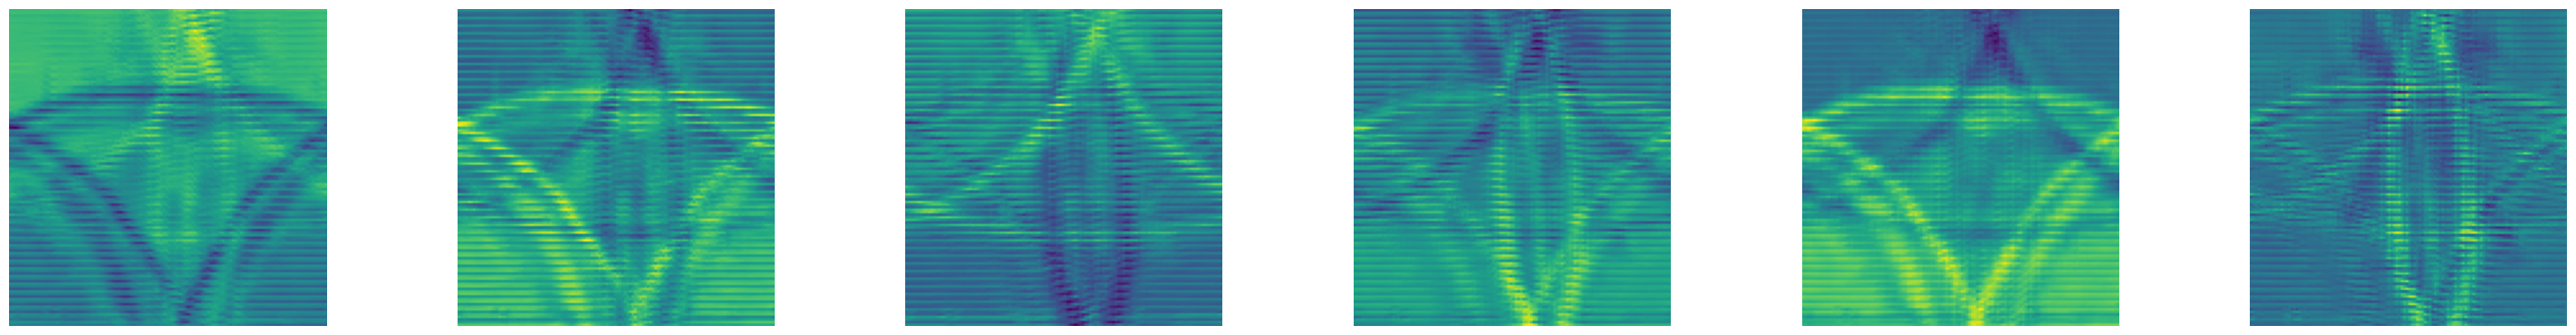

Layer  2


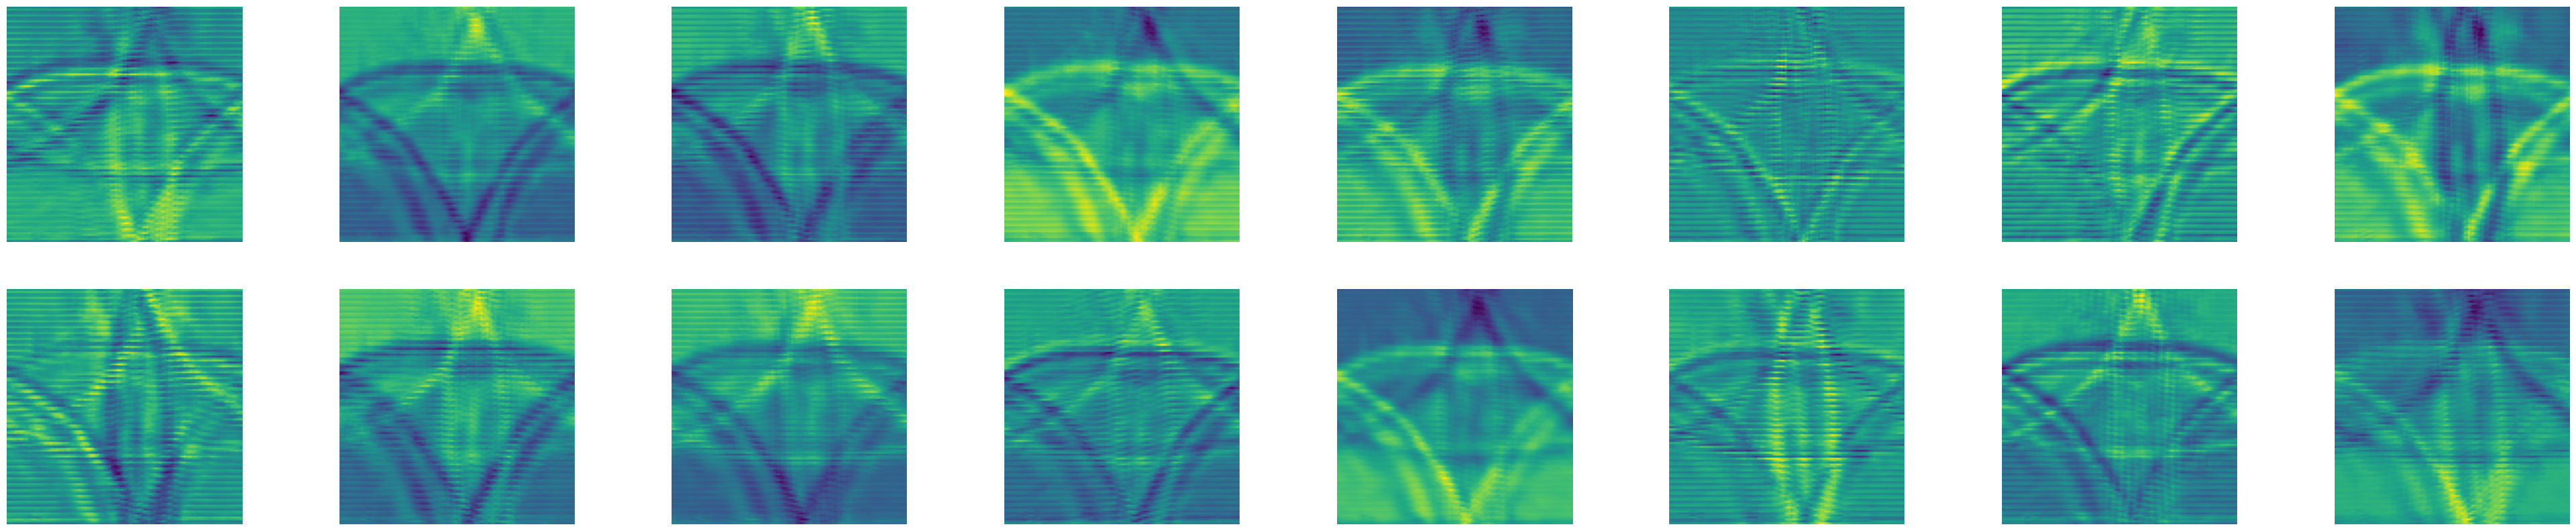

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [ ]:
class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [ ]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda:0")
model = CNN().to(device)

In [ ]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [ ]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [ ]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.686868	Val Loss: 0.684369
Train Epoch: 20	Train Loss: 0.659151	Val Loss: 0.679931
Train Epoch: 30	Train Loss: 0.591039	Val Loss: 0.625341
Train Epoch: 40	Train Loss: 0.552450	Val Loss: 0.624267
Train Epoch: 50	Train Loss: 0.583243	Val Loss: 0.650029
Train Epoch: 60	Train Loss: 0.503963	Val Loss: 0.660034
Train Epoch: 70	Train Loss: 0.446042	Val Loss: 0.664756
Train Epoch: 80	Train Loss: 0.414970	Val Loss: 0.691786
Train Epoch: 90	Train Loss: 0.417106	Val Loss: 0.734519
Train Epoch: 100	Train Loss: 0.346828	Val Loss: 0.726138
Train Epoch: 110	Train Loss: 0.339337	Val Loss: 0.800031
Train Epoch: 120	Train Loss: 0.285517	Val Loss: 0.783958
Train Epoch: 130	Train Loss: 0.269545	Val Loss: 0.799089
Train Epoch: 140	Train Loss: 0.242925	Val Loss: 0.883116
Train Epoch: 150	Train Loss: 0.281841	Val Loss: 0.901119
Train Epoch: 160	Train Loss: 0.219988	Val Loss: 0.913847
Train Epoch: 170	Train Loss: 0.187089	Val Loss: 0.962109
Train Epoch: 180	Train Loss: 0.160865	Va

Text(0, 0.5, 'Loss')

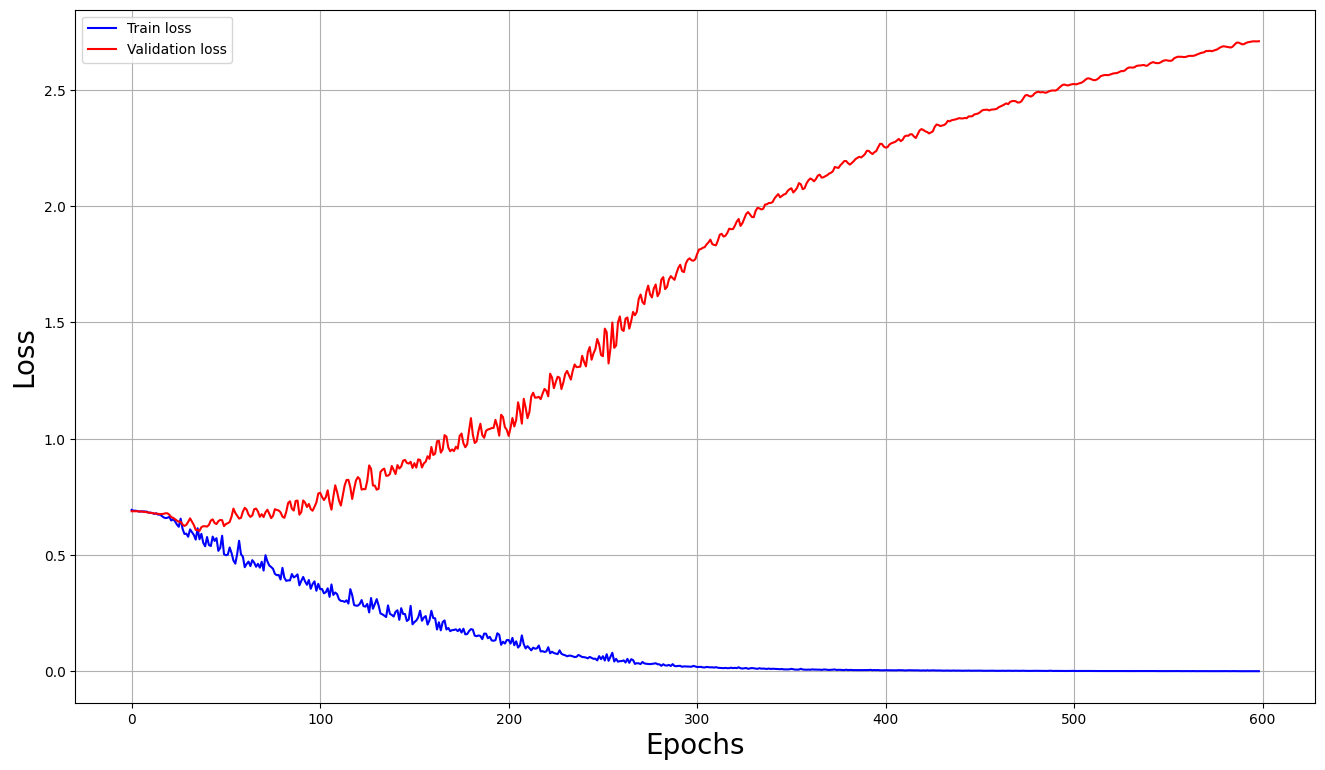

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from glob import iglob

class MRI(Dataset):
    def __init__(self, transform=None):
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.mode = 'train'  # Track whether training or validation
        self.transform = transform  # Apply transformations if provided

        # Load tumor and healthy images
        tumor, healthy = self.load_images("/content/brain_tumor_dataset/yes/*.jpg", 1)
        healthy, healthy_label = self.load_images("/content/brain_tumor_dataset/no/*.jpg", 0)

        # Concatenate images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def load_images(self, path, label):
        images = []
        for f in iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.transpose((2, 0, 1))  # Channels first for PyTorch
            images.append(img)
        labels = np.ones(len(images)) * label  # Generate labels
        return np.array(images, dtype=np.float32), labels

    def normalize(self):
        self.images /= 255.0

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
            train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        return len(self.X_train) if self.mode == 'train' else len(self.X_val)

    def __getitem__(self, idx):
        data = self.X_train[idx] if self.mode == 'train' else self.X_val[idx]
        label = self.y_train[idx] if self.mode == 'train' else self.y_val[idx]
        if self.transform:
            data = self.transform(data)
        return {'image': torch.tensor(data, dtype=torch.float32),
                'label': torch.tensor(label, dtype=torch.float32)}

# Data Augmentation
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

# Initialize dataset, normalize, and split
mri_dataset = MRI(transform=transform)
mri_dataset.normalize()
mri_dataset.train_val_split()

# Create dataloaders
train_loader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize model, optimizer, and scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Loss function
criterion = nn.BCELoss()

# Training Loop with Validation
epoch_train_loss, epoch_val_loss = [], []

for epoch in range(1, 600):
    model.train()
    mri_dataset.mode = 'train'
    train_losses = []

    for D in train_loader:
        data, label = D['image'].to(device), D['label'].to(device)

        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # Validation Step
    model.eval()
    mri_dataset.mode = 'val'
    val_losses = []

    with torch.no_grad():
        for D in val_loader:
            data, label = D['image'].to(device), D['label'].to(device)
            output = model(data).squeeze()
            loss = criterion(output, label)
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(np.mean(val_losses))  # Adjust learning rate

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {np.mean(train_losses):.6f}, '
              f'Val Loss: {np.mean(val_losses):.6f}')

# Plot Loss Curves
plt.figure(figsize=(16, 9))
plt.plot(epoch_train_loss, c='b', label='Train Loss')
plt.plot(epoch_val_loss, c='r', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid()
plt.show()


NameError: name 'tumor_label' is not defined

Epoch 10, Train Loss: 0.433885, Val Loss: 0.755615
Epoch 20, Train Loss: 0.299195, Val Loss: 0.894776
Epoch 30, Train Loss: 0.219176, Val Loss: 0.689178
Epoch 40, Train Loss: 0.291207, Val Loss: 0.668396
Epoch 50, Train Loss: 0.267140, Val Loss: 0.639717
Epoch 60, Train Loss: 0.284882, Val Loss: 0.772027
Epoch 70, Train Loss: 0.201990, Val Loss: 0.755682
Epoch 80, Train Loss: 0.231591, Val Loss: 0.510146
Epoch 90, Train Loss: 0.250191, Val Loss: 0.534229
Epoch 100, Train Loss: 0.229798, Val Loss: 0.888881
Epoch 110, Train Loss: 0.216593, Val Loss: 0.788405
Epoch 120, Train Loss: 0.232526, Val Loss: 0.866253
Epoch 130, Train Loss: 0.229520, Val Loss: 0.782331
Epoch 140, Train Loss: 0.230837, Val Loss: 0.983440
Epoch 150, Train Loss: 0.181826, Val Loss: 0.737593
Epoch 160, Train Loss: 0.303681, Val Loss: 0.557415
Epoch 170, Train Loss: 0.266313, Val Loss: 0.909316
Epoch 180, Train Loss: 0.259787, Val Loss: 0.771000
Epoch 190, Train Loss: 0.201431, Val Loss: 0.467850
Epoch 200, Train Loss

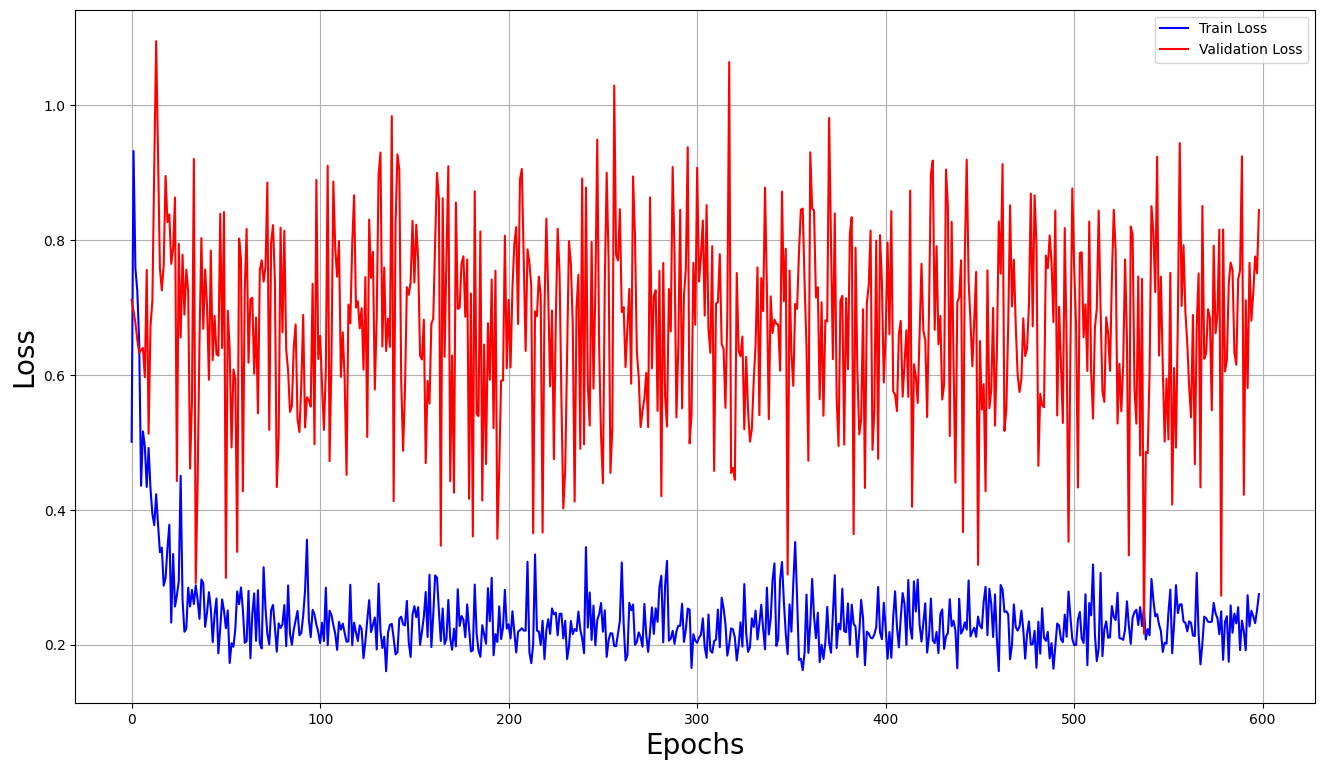

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from glob import iglob

class MRI(Dataset):
    def __init__(self, transform=None):
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.mode = 'train'  # Track whether training or validation
        self.transform = transform  # Apply transformations if provided

        # Load tumor and healthy images
        tumor, tumor_label = self.load_images("/content/brain_tumor_dataset/yes/*.jpg", 1)
        healthy, healthy_label = self.load_images("/content/brain_tumor_dataset/no/*.jpg", 0)

        # Concatenate images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def load_images(self, path, label):
        images = []
        for f in iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.transpose((2, 0, 1))  # Channels first for PyTorch
            images.append(img)
        labels = np.ones(len(images)) * label  # Generate labels
        return np.array(images, dtype=np.float32), labels

    def normalize(self):
        self.images /= 255.0

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
            train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        return len(self.X_train) if self.mode == 'train' else len(self.X_val)

    def __getitem__(self, idx):
        data = self.X_train[idx] if self.mode == 'train' else self.X_val[idx]
        label = self.y_train[idx] if self.mode == 'train' else self.y_val[idx]
        if self.transform:
            data = self.transform(torch.tensor(data))
        return {'image': data.float(), 'label': torch.tensor(label, dtype=torch.float32)}

# Data Augmentation
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

# Initialize dataset, normalize, and split
mri_dataset = MRI(transform=transform)
mri_dataset.normalize()
mri_dataset.train_val_split()

# Create dataloaders
train_loader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize model, optimizer, and scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Loss function
criterion = nn.BCELoss()

# Training Loop with Validation
epoch_train_loss, epoch_val_loss = [], []

for epoch in range(1, 600):
    model.train()
    mri_dataset.mode = 'train'
    train_losses = []

    for D in train_loader:
        data, label = D['image'].to(device), D['label'].to(device)

        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # Validation Step
    model.eval()
    mri_dataset.mode = 'val'
    val_losses = []

    with torch.no_grad():
        for D in val_loader:
            data, label = D['image'].to(device), D['label'].to(device)
            output = model(data).squeeze()
            loss = criterion(output, label)
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))
    scheduler.step(np.mean(val_losses))  # Adjust learning rate

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {np.mean(train_losses):.6f}, '
              f'Val Loss: {np.mean(val_losses):.6f}')

# Plot Loss Curves
plt.figure(figsize=(16, 9))
plt.plot(epoch_train_loss, c='b', label='Train Loss')
plt.plot(epoch_val_loss, c='r', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 42.2MB/s]


Epoch 1, Train Loss: 0.847465, Val Loss: 0.859054
Epoch 2, Train Loss: 0.835083, Val Loss: 0.838897
Epoch 3, Train Loss: 0.803645, Val Loss: 0.819336
Epoch 4, Train Loss: 0.753805, Val Loss: 0.789179
Epoch 5, Train Loss: 0.690808, Val Loss: 0.721017
Epoch 6, Train Loss: 0.635899, Val Loss: 0.699638
Epoch 7, Train Loss: 0.612531, Val Loss: 0.678509
Epoch 8, Train Loss: 0.598772, Val Loss: 0.691906
Epoch 9, Train Loss: 0.594283, Val Loss: 0.625470
Epoch 10, Train Loss: 0.622122, Val Loss: 0.708501
Epoch 11, Train Loss: 0.601079, Val Loss: 0.633472
Epoch 12, Train Loss: 0.605919, Val Loss: 0.717881
Epoch 13, Train Loss: 0.616449, Val Loss: 0.675857
Epoch 14, Train Loss: 0.614128, Val Loss: 0.644118
Epoch 15, Train Loss: 0.617842, Val Loss: 0.624620
Epoch 16, Train Loss: 0.619235, Val Loss: 0.631880
Epoch 17, Train Loss: 0.585361, Val Loss: 0.641321
Epoch 18, Train Loss: 0.588845, Val Loss: 0.621417
Epoch 19, Train Loss: 0.596898, Val Loss: 0.627868
Epoch 20, Train Loss: 0.592781, Val Loss

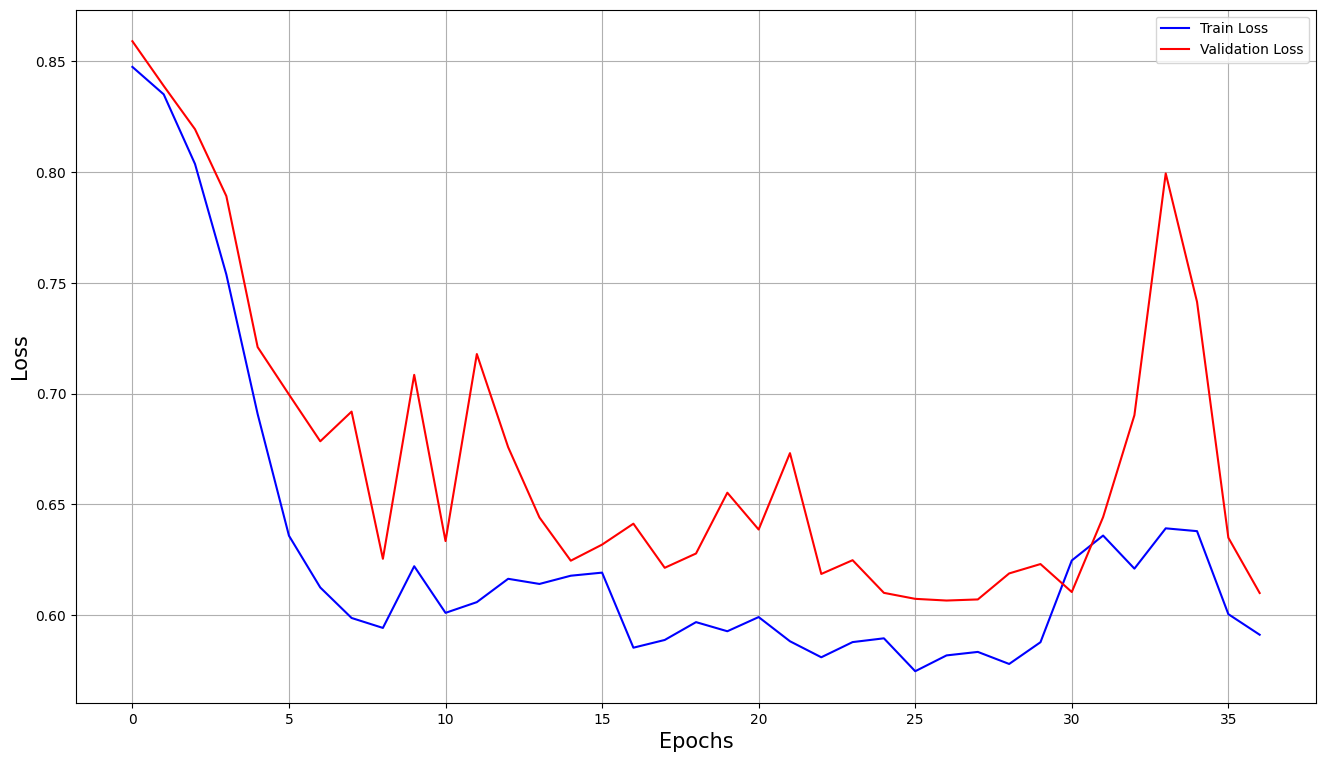

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
import cv2
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CyclicLR
from torchvision.models import efficientnet_b0
from glob import iglob

# Dataset Class
class MRI(Dataset):
    def __init__(self, transform=None):
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.mode = 'train'
        self.transform = transform

        tumor, tumor_label = self.load_images("/content/brain_tumor_dataset/yes/*.jpg", 1)
        healthy, healthy_label = self.load_images("/content/brain_tumor_dataset/no/*.jpg", 0)

        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label), axis=0)

    def load_images(self, path, label):
        images = []
        for f in iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (224, 224))  # Resize for EfficientNet
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.transpose((2, 0, 1))
            images.append(img)
        labels = np.ones(len(images)) * label
        return np.array(images, dtype=np.float32), labels

    def normalize(self):
        self.images /= 255.0

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
            train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

    def __len__(self):
        return len(self.X_train) if self.mode == 'train' else len(self.X_val)

    def __getitem__(self, idx):
        data = self.X_train[idx] if self.mode == 'train' else self.X_val[idx]
        label = self.y_train[idx] if self.mode == 'train' else self.y_val[idx]
        if self.transform:
            data = self.transform(torch.tensor(data))
        return {'image': data.float(), 'label': torch.tensor(label, dtype=torch.float32)}

# Data Augmentation
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

# Initialize dataset and split
mri_dataset = MRI(transform=transform)
mri_dataset.normalize()
mri_dataset.train_val_split()

# Dataloaders
train_loader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# Model: EfficientNet with Modified Output Layer
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        return self.sigmoid(x)

# Initialize Model, Optimizer, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorClassifier().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular')

# Handle Class Imbalance with Weighted Loss
class_weights = torch.tensor([1.0, 1.5]).to(device)  # Adjust weights if needed
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Early Stopping
best_val_loss = float('inf')
patience, trigger = 10, 0

# Training Loop with Validation and Early Stopping
epoch_train_loss, epoch_val_loss = [], []

for epoch in range(1, 301):
    # Training
    model.train()
    mri_dataset.mode = 'train'
    train_losses = []

    for batch in train_loader:
        data, label = batch['image'].to(device), batch['label'].unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # Validation
    model.eval()
    mri_dataset.mode = 'val'
    val_losses = []

    with torch.no_grad():
        for batch in val_loader:
            data, label = batch['image'].to(device), batch['label'].unsqueeze(1).to(device)
            output = model(data)
            loss = criterion(output, label)
            val_losses.append(loss.item())

    mean_val_loss = np.mean(val_losses)
    epoch_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch}, Train Loss: {epoch_train_loss[-1]:.6f}, Val Loss: {mean_val_loss:.6f}")

    # Check for Early Stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        trigger = 0  # Reset trigger if performance improves
    else:
        trigger += 1  # Increment trigger if no improvement

    if trigger >= patience:
        print("Early stopping triggered. Exiting training.")
        break

    scheduler.step()

# Plot Loss Curves
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(epoch_train_loss, label='Train Loss', color='blue')
plt.plot(epoch_val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_img = cv2.imread('/content/tumor.jpg')

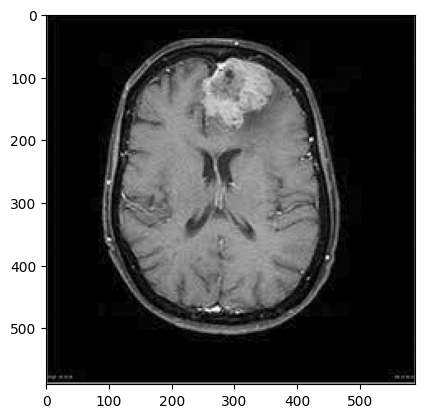

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(590, 589, 3)

In [ ]:
test_img = cv2.resize(test_img,(255,255))

In [ ]:
test_input = test_img.reshape((1,255,255,3))

In [ ]:
model.eval()

TumorClassifier(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale